# Preprocessing and integrating patient-derived AML scRNA-seq with bulk RNA-seq data

Andrew Ashford, Pathways + Omics Group - OHSU, 6/7/2024

This Jupyter Notebook will be used to explore the integration of patient-derived AML bulk RNA-seq data with scRNA-seq data.


#### Import modules

In [80]:
# Import modules
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import scanorama
import anndata as ad
import re

# Import custom modules
sys.path.append('../')
from scOPE import preprocessing


#### Specify locations and read in scRNA-seq data

In [81]:
# Save the integrated data
integrated_data_dir = '/Users/hamiltsy/Documents/GitLab/Mutation/'

# Specify h5ad filename
seurat_file = 'K22_P1_seurat_obj_final.h5ad'
#seurat_file = 'vanGalen_anndata_raw_counts_as_x.h5ad'


In [146]:
# Read in the h5ad file to an AnnData object using ScanPy module
vangalen_scrna_adata = sc.read_h5ad(integrated_data_dir + seurat_file)

#loading in BMM matrix with metadata
BMM_metadata = '/Users/hamiltsy/Documents/GitLab/Mutation/BMM_object_metadata.tsv'

BMM_matrix = pd.read_csv(BMM_metadata, sep='\t', index_col=0, on_bad_lines='skip')

print(vangalen_scrna_adata.obs_names)
#print(vangalen_scrna_adata)


Index(['AAACCAAAGAAGCCTC-1', 'AAACCAAAGATTGAAG-1', 'AAACCAAAGCAACCTA-1',
       'AAACCAAAGCGATGTC-1', 'AAACCAAAGCTATGAT-1', 'AAACCAAAGGTATCTG-1',
       'AAACCAAAGTAAGTTC-1', 'AAACCAAAGTAATCAC-1', 'AAACCAAAGTATGGTT-1',
       'AAACCATTCACTCTCG-1',
       ...
       'TGTGTACGTTTACGCG-1', 'TGTGTTAGTAATGTCC-1', 'TGTGTTAGTTAGCTTA-1',
       'TGTGTTAGTTGGATGA-1', 'TGTGTTAGTTTCACTT-1', 'TGTGTTGAGCAACTGC-1',
       'TGTGTTGAGTCAGGAG-1', 'TGTGTTGAGTGATGCC-1', 'TGTGTTGAGTGCCTGG-1',
       'TGTGTTGAGTTACCCT-1'],
      dtype='object', length=16089)


In [119]:
# Collect all unique values from the cell type columns
unique_cell_types = set()

for column in ['cell_type', 'cell_type_formatted']:
    if column in BMM_matrix.columns:
        unique_cell_types.update(BMM_matrix[column].dropna().unique())

# Print the unique cell types
print("Unique cell types in BMM_matrix:")
for cell_type in sorted(unique_cell_types):
    print(cell_type)

Unique cell types in BMM_matrix:
ASDC
BFU-E
Basophilic
Basophilic Erythroblast
CD14 Mono
CD16 Mono
CD4
CD4 Central
CD4 Central Memory
CD4 Effector
CD4 Effector Memory
CD4 Naive
CD4 Regulatory
CD8 Central
CD8 Central Memory
CD8 Effector
CD8 Effector Memory 1
CD8 Effector Memory 2
CD8 Naive
CD8 Tissue Resident
CD8 Tissue Resident Memory
CFU-E
CLP
Cycling
Cycling Progenitor
Early GMP
Early ProMono
EoBasoMast
EoBasoMast Precursor
GMP-Cycle
GMP-Mono
GMP-Neut
HSC
Immature B
LMPP
Large Pre-B
Late ProMono
MEP
MLP
MLP-II
MPP-MkEry
MPP-MyLy
Mature B
Megakaryocyte
NK
NK CD56high
NK Proliferating
Orthochromatic
Orthochromatic Erythroblast
Plasma Cell
Polychromatic
Polychromatic Erythroblast
Pre-ProB
Pre-cDC
Pre-pDC
Pre-pDC Cycling
Pro-B
Pro-B Cycling
Pro-B VDJ
Pro-Erythroblast
Small Pre-B
Stromal
T
T Proliferating
cDC1
cDC2
pDC


In [84]:
def resolve_cell_types(values):
    # Example of prioritizing certain cell types
    priority = {'T': 1, 'Small Pre-B': 2, 'NK': 3}
    values = sorted(values.unique(), key=lambda x: priority.get(x, float('inf')))
    return values[0]  # Return the highest-priority value

In [147]:
BMM_matrix

for _, row in BMM_matrix.iterrows():
    if "-1" in _:
        barcode_substring = _.split('-')[1]+"-1"
        annotated_cell_type = row['cell_type']
    
    # Find indices in AnnData where the obs_names contain the barcode substring
        matching_indices = vangalen_scrna_adata.obs_names.str.contains(barcode_substring)

        
    
    # Assign the annotated_cell_type to the matching cells in AnnData
        vangalen_scrna_adata.obs.loc[matching_indices, 'cell_type'] = cell_type

#vangalen_scrna_adata.obs = vangalen_scrna_adata.obs.merge(BMM_matrix[['barcode', 'cell_type']],
                            #left_index=True,
                            #right_on='barcode',
                            #how='left')

In [143]:
# Function to map and add the column
BMM_matrix['short_index'] = BMM_matrix.index.str.split('-').str[1]
print(BMM_matrix['short_index'])

def map_and_add(adata, anno_df):
    # Map the 'anno' column to the AnnData object's index
    mapped_values = adata.obs.index.map(anno_df.set_index('short_index')['cell_type'])
    # Assign this mapped series to a new column in adata.obs
    adata.obs['cell_type'] = mapped_values

barcode
CTGAAACTCAGAGACG   NaN
AGATCTGCATCGATTG   NaN
GATTCAGTCGGTTCGG   NaN
TGGTTCCGTAAGGATT   NaN
TACTTACAGCGATAGC   NaN
                    ..
1                  NaN
NaN                NaN
1                  NaN
1                  NaN
1                  NaN
Name: short_index, Length: 329129, dtype: float64


In [144]:
map_and_add(vangalen_scrna_adata, BMM_matrix)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [117]:
# Define the regex pattern to match barcodes
# barcode_pattern = re.comp(r'[A-Z]{16}-1')  # Adjusted to include prefixes


#print(BMM_matrix.index)

# Update the index to match the desired syntax
#new_index = []

#for idx in BMM_matrix.index:
    #match = re.search(r'[A-Z]{16}-1', idx)
    #if match:
        #new_index.append(match.group(0))
    #else:
        #new_index.append('NA')
        
#BMM_matrix.index = new_index

# Create a new column 'cell_barcode' in the DataFrame
#vangalen_scrna_adata.obs['cell_barcode'] = vangalen_scrna_adata.obs.index.str.split('-').str[0]

#BMM_matrix_cleaned = BMM_matrix.groupby(BMM_matrix.index).first()

#BMM_matrix_cleaned = BMM_matrix.groupby(BMM_matrix.index).agg(resolve_cell_types)

#print(BMM_matrix)
#print(BMM_matrix_cleaned)

#print(BMM_matrix.index)

#vangalen_scrna_adata.obs['cell_type'] = BMM_matrix_cleaned['cell_type']

#vangalen_scrna_adata.obs['cell_type_formatted'] = BMM_matrix_cleaned['cell_type_formatted']



#print(BMM_matrix_cleaned['cell_type_formatted'])

#print(vangalen_scrna_adata.obs['cell_type_formatted'])


#for index in vangalen_scrna_adata.obs.index:
    #cell_barcode = index.split('-')[0]
    #vangalen_scrna_adata.obs.loc[index, 'cell_barcode'] = cell_barcode

#print(vangalen_scrna_adata.obs_names) = BMM_matrix.index


Index(['CTGAAACTCAGAGACG-1', 'AGATCTGCATCGATTG-1', 'GATTCAGTCGGTTCGG-1',
       'TGGTTCCGTAAGGATT-1', 'TACTTACAGCGATAGC-1', 'GCAGTTAGTACGAAAT-1',
       'AGAGCGAAGGCATTGG-1', 'GGGCATCTCAACCAAC-1', 'GACCTGGCACTATCTT-1',
       'GGGAGATGTCTCCACT-1',
       ...
       'TTTCCTCGTCAGAGGT-1', 'TTTCCTCTCAGAGACG-1', 'TTTGCGCAGAATGTTG-1', 'NA',
       'TTTGGTTGTAATCGTC-1', 'TTTGGTTGTTTGACTG-1', 'NA', 'TTTGTCAAGGATTCGG-1',
       'TTTGTCAAGGTCATCT-1', 'TTTGTCAGTTGCGCAC-1'],
      dtype='object', length=329129)


In [148]:
vangalen_scrna_adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,cell_type
AAACCAAAGAAGCCTC-1,0,9279.0,2915,NaN
AAACCAAAGATTGAAG-1,0,1330.0,506,NaN
AAACCAAAGCAACCTA-1,0,3472.0,1460,NaN
AAACCAAAGCGATGTC-1,0,5875.0,2315,NaN
AAACCAAAGCTATGAT-1,0,7561.0,2260,NaN
...,...,...,...,...
TGTGTTGAGCAACTGC-1,0,6852.0,2157,NaN
TGTGTTGAGTCAGGAG-1,0,566.0,382,NaN
TGTGTTGAGTGATGCC-1,0,7631.0,2398,NaN
TGTGTTGAGTGCCTGG-1,0,11356.0,3905,NaN


In [72]:
print(BMM_matrix.index)
print(BMM_matrix_cleaned['cell_type_formatted'])
print(vangalen_scrna_adata.obs_names)
print(vangalen_scrna_adata.obs['cell_type_formatted'])
print(vangalen_scrna_adata)

Index(['CTGAAACTCAGAGACG-1', 'AGATCTGCATCGATTG-1', 'GATTCAGTCGGTTCGG-1',
       'TGGTTCCGTAAGGATT-1', 'TACTTACAGCGATAGC-1', 'GCAGTTAGTACGAAAT-1',
       'AGAGCGAAGGCATTGG-1', 'GGGCATCTCAACCAAC-1', 'GACCTGGCACTATCTT-1',
       'GGGAGATGTCTCCACT-1',
       ...
       'TTTCCTCGTCAGAGGT-1', 'TTTCCTCTCAGAGACG-1', 'TTTGCGCAGAATGTTG-1', 'NA',
       'TTTGGTTGTAATCGTC-1', 'TTTGGTTGTTTGACTG-1', 'NA', 'TTTGTCAAGGATTCGG-1',
       'TTTGTCAAGGTCATCT-1', 'TTTGTCAGTTGCGCAC-1'],
      dtype='object', length=329129)
AAACCCAAGATGCAGC-1     CD4 Central
AAACCCACAAACTCGT-1    Late ProMono
AAACCCACAGTGTACT-1       CD14 Mono
AAACCCAGTCCTCATC-1              NK
AAACCCAGTCGCATTA-1       CD8 Naive
                          ...     
TTTGTTGCATTGAAAG-1        Mature B
TTTGTTGGTGCAACAG-1              NK
TTTGTTGGTGTTACAC-1     NK CD56high
TTTGTTGTCTAGTCAG-1             HSC
TTTGTTGTCTTGGTGA-1     CD4 Central
Name: cell_type_formatted, Length: 202034, dtype: object
Index(['AAACCAAAGAAGCCTC-1', 'AAACCAAAGATTGAAG-1', '

In [8]:
# Assuming 'vangalen_scrna_adata' is your object and 'cell_type' is in .obs
if 'cell_type' in vangalen_scrna_adata.obs.columns:
    # Collect all unique cell types
    unique_cell_types = vangalen_scrna_adata.obs['cell_type'].dropna().unique()
    
    # Print the unique cell types
    print("Unique cell types in vangalen_scrna_adata:")
    for cell_type in sorted(unique_cell_types):
        print(cell_type)
else:
    print("'cell_type' column not found in vangalen_scrna_adata.obs")

Unique cell types in vangalen_scrna_adata:
CD8 Effector Memory 2


In [9]:
print(vangalen_scrna_adata)

AnnData object with n_obs × n_vars = 16089 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_barcode', 'cell_type', 'cell_type_formatted'
    var: 'features'


In [10]:
# Sanity check - make sure loaded in properly
# NOTE: Data is already normalized
'''
print(vangalen_scrna_adata)
print(vangalen_scrna_adata.X)
print(vangalen_scrna_adata.X.min())
print(vangalen_scrna_adata.X.max())
'''
print(vangalen_scrna_adata.obs_names)


Index(['AAACCAAAGAAGCCTC-1', 'AAACCAAAGATTGAAG-1', 'AAACCAAAGCAACCTA-1',
       'AAACCAAAGCGATGTC-1', 'AAACCAAAGCTATGAT-1', 'AAACCAAAGGTATCTG-1',
       'AAACCAAAGTAAGTTC-1', 'AAACCAAAGTAATCAC-1', 'AAACCAAAGTATGGTT-1',
       'AAACCATTCACTCTCG-1',
       ...
       'TGTGTACGTTTACGCG-1', 'TGTGTTAGTAATGTCC-1', 'TGTGTTAGTTAGCTTA-1',
       'TGTGTTAGTTGGATGA-1', 'TGTGTTAGTTTCACTT-1', 'TGTGTTGAGCAACTGC-1',
       'TGTGTTGAGTCAGGAG-1', 'TGTGTTGAGTGATGCC-1', 'TGTGTTGAGTGCCTGG-1',
       'TGTGTTGAGTTACCCT-1'],
      dtype='object', length=16089)


In [11]:
# Make new AnnData object with raw values as .X to ensure normalization and scaling accuracy
import anndata as ad
import numpy as np

# Ensure vangalen_scrna_adata.raw is not None and extract raw counts
if vangalen_scrna_adata.raw is not None:
    raw_counts = vangalen_scrna_adata.raw.X.copy()
else:
    raise ValueError("vangalen_scrna_adata.raw is None. Ensure the raw data is available.")

# Create a new AnnData object with raw counts
vangalen_scrna_raw_adata = ad.AnnData(X=raw_counts, obs=vangalen_scrna_adata.obs.copy())

# Copy over the uns, obsm, varm, obsp, and layers attributes if they exist
vangalen_scrna_raw_adata.uns = vangalen_scrna_adata.uns.copy()
vangalen_scrna_raw_adata.obsm = vangalen_scrna_adata.obsm.copy()
vangalen_scrna_raw_adata.varm = vangalen_scrna_adata.varm.copy()
vangalen_scrna_raw_adata.obsp = vangalen_scrna_adata.obsp.copy()
vangalen_scrna_raw_adata.layers = vangalen_scrna_adata.layers.copy()

# Need to set vangalen_scrna_raw_adata.var_names to gene names
vangalen_scrna_raw_adata.var_names = vangalen_scrna_adata.var_names

# Print the new AnnData object to verify
print(vangalen_scrna_raw_adata)
print(vangalen_scrna_raw_adata.var_names)


AnnData object with n_obs × n_vars = 16089 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_barcode', 'cell_type', 'cell_type_formatted'
Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)


#### Specify locations and read in bulk RNA-seq data

In [12]:
# Specify directory and filename of the Beat AML bulk RNA-seq data
# NOTE: I'm using the raw counts for this step
counts_dir = '/Users/hamiltsy/Documents/GitLab/Mutation/beatAML_data/'
counts_filename = 'beataml_waves1to4_counts_dbgap.txt'


In [13]:
# Load the data using custom preprocessing module
counts_df = preprocessing.tsv_to_df(counts_dir + counts_filename, index_col = 0)

# Sanity check
print(counts_df)


                 display_label  \
stable_id                        
ENSG00000000003         TSPAN6   
ENSG00000000005           TNMD   
ENSG00000000419           DPM1   
ENSG00000000457          SCYL3   
ENSG00000000460       C1orf112   
...                        ...   
ENSG00000273489  RP11-180C16.1   
ENSG00000273490         TSEN34   
ENSG00000273491   RP11-138A9.2   
ENSG00000273492     AP000230.1   
ENSG00000273493   RP11-80H18.4   

                                                       description  \
stable_id                                                            
ENSG00000000003       tetraspanin 6 [Source:HGNC Symbol;Acc:11858]   
ENSG00000000005         tenomodulin [Source:HGNC Symbol;Acc:17757]   
ENSG00000000419  dolichyl-phosphate mannosyltransferase polypep...   
ENSG00000000457  SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...   
ENSG00000000460  chromosome 1 open reading frame 112 [Source:HG...   
...                                                            ... 

In [18]:
# Replace the gene IDs with gene names so we can match the gene names with the scRNA-seq data
# Also eliminate all columns except for counts columns
def process_bulk_data(df):
    # Set the display_label as the new index
    df = df.set_index('display_label')
    
    # Select only the columns that contain patient RNA counts
    patient_columns = df.columns[df.columns.str.contains(r'^BA\d{4}R$')]
    df = df[patient_columns]
    
    return df


In [19]:
counts_only_df = process_bulk_data(counts_df)

# Sanity check
print(counts_only_df)


               BA2392R  BA2611R  BA2506R  BA2430R  BA2448R  BA2730R  BA2845R  \
display_label                                                                  
TSPAN6              80       58      110       89       76       75      111   
TNMD                 0        0        0        0        0        0        0   
DPM1              1000      520     1092      831      762      645     1811   
SCYL3              621      364      805      531      566      448     1060   
C1orf112           789      522     1007      791      706      601     1263   
...                ...      ...      ...      ...      ...      ...      ...   
RP11-180C16.1        0        0        0        1        0        0        4   
TSEN34               0        0        0        0        0        0        0   
RP11-138A9.2         0        0        0        0        0        0        0   
AP000230.1           0        0        0        0        2        1        0   
RP11-80H18.4         1        1        2

In [20]:
# Make sure the rows are samples and the columns are genes
counts_only_df = counts_only_df.T


In [21]:
# Create AnnData object using Scanpy
bulk_data = sc.AnnData(X=counts_only_df.values, obs=pd.DataFrame(index=counts_only_df.index), var=pd.DataFrame(index=counts_only_df.columns))


/Users/hamiltsy/miniconda3/envs/jupyter/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [22]:
# Sanity check
print(bulk_data)
print(bulk_data.X)
print(bulk_data.X.min())
print(bulk_data.X.max())


AnnData object with n_obs × n_vars = 707 × 63677
[[  80    0 1000 ...    0    0    1]
 [  58    0  520 ...    0    0    1]
 [ 110    0 1092 ...    0    0    2]
 ...
 [   4    0 1506 ...    0    0    1]
 [   1    0 1841 ...    0    0    5]
 [   4    0 1068 ...    0    0    1]]
0
4404579


#### Preprocess data - scRNA-seq

In [23]:
print(vangalen_scrna_raw_adata)
print(vangalen_scrna_raw_adata.obs["nCount_RNA"])
print(vangalen_scrna_raw_adata.obs["nCount_RNA"].min())
print(vangalen_scrna_raw_adata.obs["nCount_RNA"].max())

AnnData object with n_obs × n_vars = 16089 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_barcode', 'cell_type', 'cell_type_formatted'
AAACCAAAGAAGCCTC-1     9279.0
AAACCAAAGATTGAAG-1     1330.0
AAACCAAAGCAACCTA-1     3472.0
AAACCAAAGCGATGTC-1     5875.0
AAACCAAAGCTATGAT-1     7561.0
                       ...   
TGTGTTGAGCAACTGC-1     6852.0
TGTGTTGAGTCAGGAG-1      566.0
TGTGTTGAGTGATGCC-1     7631.0
TGTGTTGAGTGCCTGG-1    11356.0
TGTGTTGAGTTACCCT-1     5120.0
Name: nCount_RNA, Length: 16089, dtype: float64
500.0
85690.0


In [24]:
print(vangalen_scrna_raw_adata.obs["nCount_RNA"])
print(vangalen_scrna_raw_adata.obs["nCount_RNA"].min())
print(vangalen_scrna_raw_adata.obs["nCount_RNA"].max())

AAACCAAAGAAGCCTC-1     9279.0
AAACCAAAGATTGAAG-1     1330.0
AAACCAAAGCAACCTA-1     3472.0
AAACCAAAGCGATGTC-1     5875.0
AAACCAAAGCTATGAT-1     7561.0
                       ...   
TGTGTTGAGCAACTGC-1     6852.0
TGTGTTGAGTCAGGAG-1      566.0
TGTGTTGAGTGATGCC-1     7631.0
TGTGTTGAGTGCCTGG-1    11356.0
TGTGTTGAGTTACCCT-1     5120.0
Name: nCount_RNA, Length: 16089, dtype: float64
500.0
85690.0


In [25]:
# Step 1: Normalize the total counts per cell
sc.pp.normalize_total(vangalen_scrna_raw_adata, target_sum=1e4)


In [26]:
print(vangalen_scrna_raw_adata.obs["nCount_RNA"])
print(vangalen_scrna_raw_adata.obs["nCount_RNA"].min())
print(vangalen_scrna_raw_adata.obs["nCount_RNA"].max())

AAACCAAAGAAGCCTC-1     9279.0
AAACCAAAGATTGAAG-1     1330.0
AAACCAAAGCAACCTA-1     3472.0
AAACCAAAGCGATGTC-1     5875.0
AAACCAAAGCTATGAT-1     7561.0
                       ...   
TGTGTTGAGCAACTGC-1     6852.0
TGTGTTGAGTCAGGAG-1      566.0
TGTGTTGAGTGATGCC-1     7631.0
TGTGTTGAGTGCCTGG-1    11356.0
TGTGTTGAGTTACCCT-1     5120.0
Name: nCount_RNA, Length: 16089, dtype: float64
500.0
85690.0


In [27]:
# Step 2: Log1p transformation
sc.pp.log1p(vangalen_scrna_raw_adata)


In [28]:
print(vangalen_scrna_raw_adata.obs["nCount_RNA"])
print(vangalen_scrna_raw_adata.obs["nCount_RNA"].min())
print(vangalen_scrna_raw_adata.obs["nCount_RNA"].max())

AAACCAAAGAAGCCTC-1     9279.0
AAACCAAAGATTGAAG-1     1330.0
AAACCAAAGCAACCTA-1     3472.0
AAACCAAAGCGATGTC-1     5875.0
AAACCAAAGCTATGAT-1     7561.0
                       ...   
TGTGTTGAGCAACTGC-1     6852.0
TGTGTTGAGTCAGGAG-1      566.0
TGTGTTGAGTGATGCC-1     7631.0
TGTGTTGAGTGCCTGG-1    11356.0
TGTGTTGAGTTACCCT-1     5120.0
Name: nCount_RNA, Length: 16089, dtype: float64
500.0
85690.0


In [57]:
# Step 3: Calculate QC metrics
#vangalen_scrna_raw_adata.var['mt'] = vangalen_scrna_raw_adata.var_names.str.startswith('MT-')
#sc.pp.calculate_qc_metrics(vangalen_scrna_raw_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


In [29]:
print(vangalen_scrna_raw_adata.obs["nCount_RNA"])
print(vangalen_scrna_raw_adata.obs["nCount_RNA"].min())
print(vangalen_scrna_raw_adata.obs["nCount_RNA"].max())


AAACCAAAGAAGCCTC-1     9279.0
AAACCAAAGATTGAAG-1     1330.0
AAACCAAAGCAACCTA-1     3472.0
AAACCAAAGCGATGTC-1     5875.0
AAACCAAAGCTATGAT-1     7561.0
                       ...   
TGTGTTGAGCAACTGC-1     6852.0
TGTGTTGAGTCAGGAG-1      566.0
TGTGTTGAGTGATGCC-1     7631.0
TGTGTTGAGTGCCTGG-1    11356.0
TGTGTTGAGTTACCCT-1     5120.0
Name: nCount_RNA, Length: 16089, dtype: float64
500.0
85690.0


In [30]:
# Step 4: Filter out low-quality cells
# Example criteria: cells with less than 200 genes, more than 2,500 genes, or more than 5% mitochondrial counts
#sc.pp.filter_cells(vangalen_scrna_raw_adata, min_genes=200)
#sc.pp.filter_cells(vangalen_scrna_raw_adata, max_genes=2500)
#vangalen_scrna_raw_adata = vangalen_scrna_raw_adata[vangalen_scrna_raw_adata.obs.pct_counts_mt < 5, :]


In [31]:
# Step 5: Filter out low-quality genes
# Example criteria: genes expressed in less than 3 cells
sc.pp.filter_genes(vangalen_scrna_raw_adata, min_cells=3)


In [32]:
# Select highly variable genes
sc.pp.highly_variable_genes(vangalen_scrna_raw_adata, n_top_genes=7000)


In [33]:
# Filter to just the highly-variable gene features
vangalen_scrna_raw_adata = vangalen_scrna_raw_adata[:, vangalen_scrna_raw_adata.var.highly_variable]


In [34]:
# Scale the data (center to zero mean and scale to unit variance)
sc.pp.scale(vangalen_scrna_raw_adata, zero_center=True, max_value=10)

# Can also just scale to Z-scores like this (center to zero mean and scale to unit variance)
#sc.pp.scale(vangalen_scrna_adata, zero_center=True)


/Users/hamiltsy/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [35]:
# Sanity check
print(vangalen_scrna_raw_adata)
print(vangalen_scrna_raw_adata.X)
print(vangalen_scrna_raw_adata.X.min())
print(vangalen_scrna_raw_adata.X.max())


AnnData object with n_obs × n_vars = 16089 × 7000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_barcode', 'cell_type', 'cell_type_formatted'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
[[-0.12086523 -0.09753989 -0.04009668 ... -0.07455742 -0.17650304
  -0.01412698]
 [-0.12086523 -0.09753989 -0.04009668 ... -0.07455742 -0.17650304
  -0.01412698]
 [-0.12086523 -0.09753989 -0.04009668 ... -0.07455742 -0.17650304
  -0.01412698]
 ...
 [-0.12086523 -0.09753989 -0.04009668 ... -0.07455742 -0.17650304
  -0.01412698]
 [-0.12086523 -0.09753989 -0.04009668 ... -0.07455742 -0.17650304
  -0.01412698]
 [-0.12086523 -0.09753989 -0.04009668 ... -0.07455742 -0.17650304
  -0.01412698]]
-7.6468078366926475
10.0


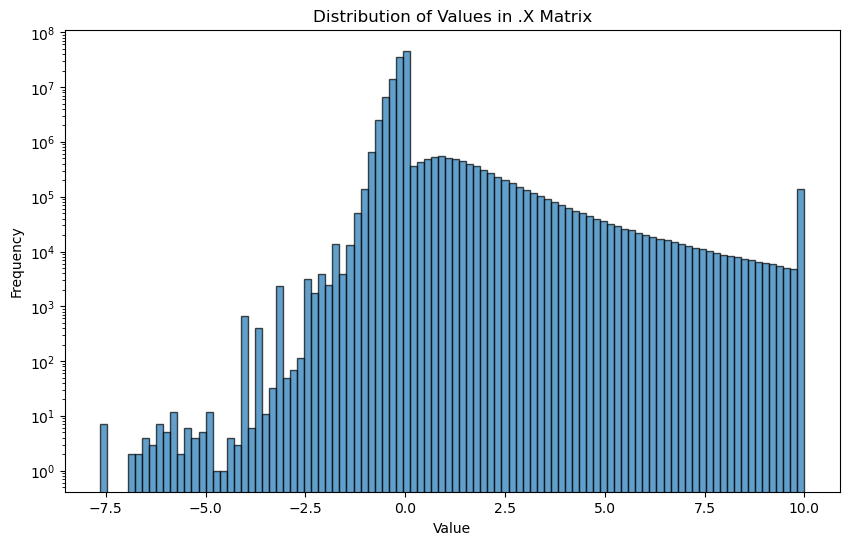

In [36]:
# Flatten the .X matrix to a 1D array
data_flattened = vangalen_scrna_raw_adata.X.flatten()

# Plot a histogram of the values
plt.figure(figsize=(10, 6))
plt.hist(data_flattened, bins=100, edgecolor='k', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Values in .X Matrix')
plt.yscale('log')  # Optional: Use a logarithmic scale for better visibility of small frequencies
plt.show()


#### Preprocess data - bulk RNA-seq data

In [37]:
print(bulk_data)

AnnData object with n_obs × n_vars = 707 × 63677


In [38]:
# Preprocess bulk RNA-seq data
sc.pp.normalize_total(bulk_data, target_sum=1e4)
sc.pp.log1p(bulk_data)


In [39]:
print(bulk_data)

AnnData object with n_obs × n_vars = 707 × 63677
    uns: 'log1p'


In [40]:
# Maybe filter by gene counts for samples since the max raw count in the bulk RNA-seq data is 4404579
#sc.pp.filter_cells(vangalen_scrna_raw_adata, min_genes=200)
#sc.pp.filter_cells(vangalen_scrna_raw_adata, max_genes=200000)


In [41]:
sc.pp.highly_variable_genes(bulk_data, n_top_genes=20000)  # Adjust as needed
bulk_data = bulk_data[:, bulk_data.var.highly_variable]


In [42]:
# Scale the data the same as above
sc.pp.scale(bulk_data, zero_center=True, max_value=10)


/Users/hamiltsy/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/hamiltsy/miniconda3/envs/jupyter/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/hamiltsy/miniconda3/envs/jupyter/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


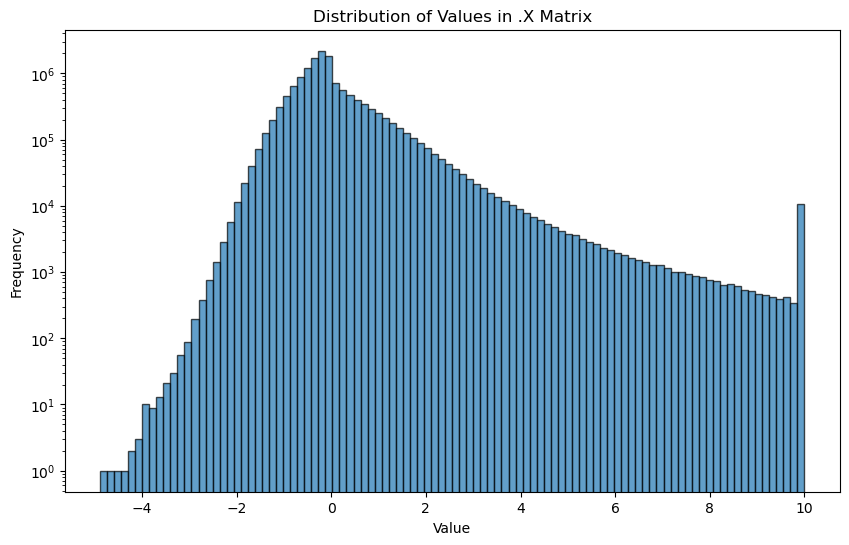

In [43]:
# Flatten the .X matrix to a 1D array
data_flattened = bulk_data.X.flatten()

# Plot a histogram of the values
plt.figure(figsize=(10, 6))
plt.hist(data_flattened, bins=100, edgecolor='k', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Values in .X Matrix')
plt.yscale('log')  # Optional: Use a logarithmic scale for better visibility of small frequencies
plt.show()


#### Filter by shared gene features and merge AnnData objects

In [44]:
# Check for duplicates in gene names
bulk_duplicates = bulk_data.var_names[bulk_data.var_names.duplicated()]
sc_duplicates = vangalen_scrna_raw_adata.var_names[vangalen_scrna_raw_adata.var_names.duplicated()]

# Print the duplicates (if any)
print("Bulk duplicates:", bulk_duplicates)
print("Single-cell duplicates:", sc_duplicates)


Bulk duplicates: Index(['TMEM236', 'Y_RNA', 'Y_RNA', 'Y_RNA', 'Y_RNA', 'Y_RNA', 'Y_RNA',
       'Y_RNA', 'Y_RNA', 'Y_RNA', 'Y_RNA', 'Y_RNA', 'Y_RNA', 'Y_RNA', 'Y_RNA',
       'Y_RNA', 'Y_RNA', 'U3', 'Y_RNA', 'NPIPA7', 'SRSF10', 'PNRC2', 'ZNF84',
       'FRG2C', 'KBTBD4', 'NPIPA7', 'CRYBG3', 'ZNF26', 'snoU13', 'U1',
       'snoU13', 'snoU13', 'snoU13', 'snoU13', 'snoU13', 'snoU13', 'snoU13',
       'snoU13', 'Y_RNA', 'snoU13', 'snoU13', 'KIR3DL2', 'RNA5-8S5', 'Y_RNA',
       'snoU13', 'SNORA66', 'Y_RNA', 'Y_RNA', 'Y_RNA', 'Y_RNA', 'LIMS3',
       'CRIP1', 'NAA60', 'U3', 'SCARNA17', 'CKS1B', 'GOLGA7B', 'ZNF33B',
       'POLR2J4'],
      dtype='object', name='display_label')
Single-cell duplicates: Index([], dtype='object')


In [45]:
print(bulk_data)
print(vangalen_scrna_raw_adata)


AnnData object with n_obs × n_vars = 707 × 20000
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
AnnData object with n_obs × n_vars = 16089 × 7000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_barcode', 'cell_type', 'cell_type_formatted'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'


In [46]:
print(bulk_data.var_names)
vangalen_scrna_raw_adata.var_names


Index(['TSPAN6', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'GCLC', 'STPG1', 'NIPAL3',
       'ENPP4', 'SEMA3F',
       ...
       'RP11-1399P15.1', 'AC004067.5', 'RP11-166O4.6', 'RP11-218F10.3',
       'RP11-686O6.2', 'RP11-548H3.1', 'RP11-102N12.3', 'RP11-196O16.1',
       'RP11-731C17.2', 'RP11-114I8.4'],
      dtype='object', name='display_label', length=20000)


Index(['AL627309.5', 'LINC00115', 'AL645608.2', 'LINC02593', 'SAMD11',
       'KLHL17', 'PLEKHN1', 'AL645608.7', 'HES4', 'ISG15',
       ...
       'MT-ATP8', 'MT-ATP6', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6',
       'BX004987.1', 'AL354822.1', 'AC233755.1'],
      dtype='object', length=7000)

In [47]:
# Remove duplicates (if necessary)
bulk_data = bulk_data[:, ~bulk_data.var_names.duplicated()]
vangalen_scrna_raw_adata = vangalen_scrna_raw_adata[:, ~vangalen_scrna_raw_adata.var_names.duplicated()]


In [48]:
print(bulk_data)
print(vangalen_scrna_raw_adata)


View of AnnData object with n_obs × n_vars = 707 × 19941
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
View of AnnData object with n_obs × n_vars = 16089 × 7000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_barcode', 'cell_type', 'cell_type_formatted'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'


In [49]:
# Find common genes
common_genes = vangalen_scrna_raw_adata.var_names.intersection(bulk_data.var_names)

print(common_genes)


Index(['LINC00115', 'SAMD11', 'KLHL17', 'PLEKHN1', 'HES4', 'ISG15', 'TTLL10',
       'SCNN1D', 'TAS1R3', 'AL645728.1',
       ...
       'TMLHE', 'TTTY10', 'MT-CO1', 'MT-ATP8', 'MT-ATP6', 'MT-ND3', 'MT-ND4L',
       'MT-ND4', 'MT-ND6', 'AL354822.1'],
      dtype='object', length=3631)


In [50]:
# Make it so both objects only contain common genes
vangalen_scrna_raw_adata = vangalen_scrna_raw_adata[:, common_genes]
bulk_data = bulk_data[:, common_genes]


In [51]:
# Combine the datasets
combined_data = vangalen_scrna_raw_adata.concatenate(bulk_data, batch_key='dataset')

# Sanity check
print(combined_data)


/var/folders/2k/tcn7b4hn3c9dls2qttgfhg84_b9kmx/T/ipykernel_69724/903914684.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = vangalen_scrna_raw_adata.concatenate(bulk_data, batch_key='dataset')


AnnData object with n_obs × n_vars = 16796 × 3631
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_barcode', 'cell_type', 'cell_type_formatted', 'dataset'
    var: 'highly_variable', 'n_cells-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'mean-1', 'std-1'


In [52]:
print(combined_data.obs['orig.ident'])
print(combined_data.obs['MutTranscripts'])


AAACCAAAGAAGCCTC-1-0    0.0
AAACCAAAGATTGAAG-1-0    0.0
AAACCAAAGCAACCTA-1-0    0.0
AAACCAAAGCGATGTC-1-0    0.0
AAACCAAAGCTATGAT-1-0    0.0
                       ... 
BA3385R-1               NaN
BA3242R-1               NaN
BA3446R-1               NaN
BA3416R-1               NaN
BA3123R-1               NaN
Name: orig.ident, Length: 16796, dtype: float64


KeyError: 'MutTranscripts'

In [53]:
print(combined_data.obs['dataset'])


AAACCAAAGAAGCCTC-1-0    0
AAACCAAAGATTGAAG-1-0    0
AAACCAAAGCAACCTA-1-0    0
AAACCAAAGCGATGTC-1-0    0
AAACCAAAGCTATGAT-1-0    0
                       ..
BA3385R-1               1
BA3242R-1               1
BA3446R-1               1
BA3416R-1               1
BA3123R-1               1
Name: dataset, Length: 16796, dtype: category
Categories (2, object): ['0', '1']


In [54]:
# Save combined data
save_dir = '/Users/hamiltsy/Documents/GitLab/Mutation/'
combined_data.write(save_dir + 'combined_Beat_AML_K22_AML_adata.h5ad')


In [55]:
# Save combined data
#save_dir = '/Users/hamiltsy/Documents/GitLab/Mutation/'
#combined_data.write(save_dir + 'combined_Beat_AML_K22_AML_adata.h5ad')


In [56]:
# Build UMAP
sc.tl.pca(combined_data)
sc.pp.neighbors(combined_data)
sc.tl.umap(combined_data)


/Users/hamiltsy/miniconda3/envs/jupyter/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


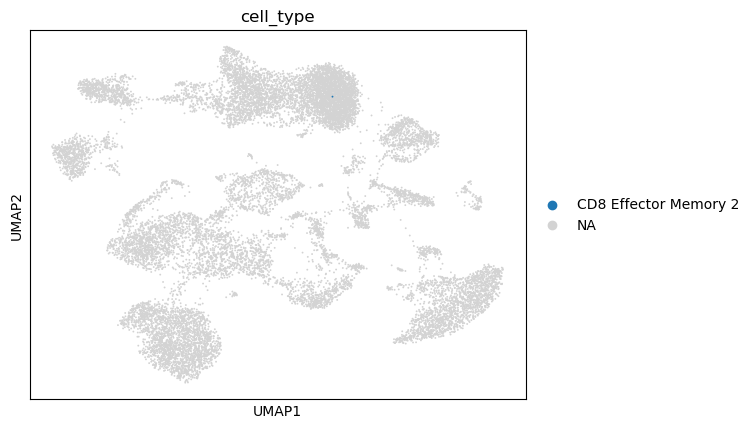

In [87]:
# Plot UMAP
sc.pl.umap(combined_data, color=['cell_type'])


In [163]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(combined_data, flavor="igraph", n_iterations=2)


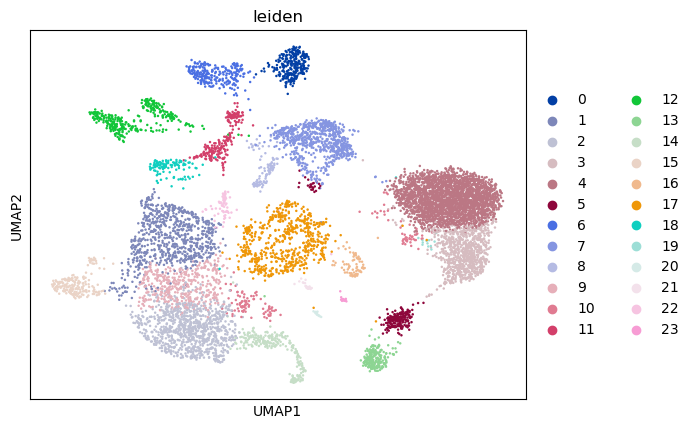

In [164]:
sc.pl.umap(combined_data, color=["leiden"])

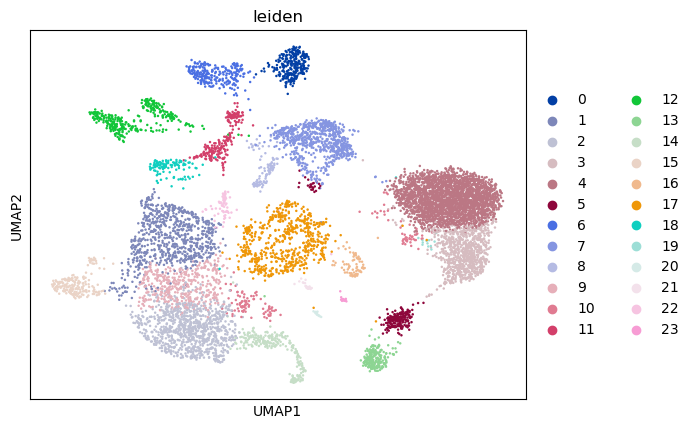

In [165]:
# Plot UMAP
sc.pl.umap(combined_data, color=['leiden'])


In [166]:
print(combined_data.obs_names)
genes_to_check = ['CCR7', 'CD247', 'CD4', 'CLEC10A', 'FCER1A', 'GYPA', 'HSP90B1', 'IGKC', 'IL4R', 'ITGB1', 'JCHAIN', 'LEF1', 'PLCG2', 'SYNGR1', 'TCF7', 'TRBC2', 'XBP1']
found_genes = [gene for gene in genes_to_check if gene in combined_data.var_names]
missing_genes = [gene for gene in genes_to_check if gene not in combined_data.var_names]
print(f"Found genes: {found_genes}")
print(f"Missing genes: {missing_genes}")

Index(['AAACCAAAGATTGAAG-1-0', 'AAACCAAAGCAACCTA-1-0', 'AAACCAAAGCGATGTC-1-0',
       'AAACCAAAGCTATGAT-1-0', 'AAACCAAAGGTATCTG-1-0', 'AAACCAAAGTAATCAC-1-0',
       'AAACCAAAGTATGGTT-1-0', 'AAACCATTCGTCTCAT-1-0', 'AAACCCGCAACCATCC-1-0',
       'AAACCCGCAATCGGGC-1-0',
       ...
       'BA3376R-1', 'BA3137R-1', 'BA3300R-1', 'BA3375R-1', 'BA3249R-1',
       'BA3385R-1', 'BA3242R-1', 'BA3446R-1', 'BA3416R-1', 'BA3123R-1'],
      dtype='object', length=9471)
Found genes: ['GYPA']
Missing genes: ['CCR7', 'CD247', 'CD4', 'CLEC10A', 'FCER1A', 'HSP90B1', 'IGKC', 'IL4R', 'ITGB1', 'JCHAIN', 'LEF1', 'PLCG2', 'SYNGR1', 'TCF7', 'TRBC2', 'XBP1']


In [167]:
print(combined_data.var_names[:10])  # Display the first 10 entries in `var_names`



Index(['LINC00115', 'SAMD11', 'HES4', 'ISG15', 'SCNN1D', 'TAS1R3', 'ATAD3A',
       'AL645728.1', 'CDK11A', 'NADK'],
      dtype='object')


In [168]:
ident_as_str = combined_data
ident_as_str.obs['orig.ident'] = ident_as_str.obs['orig.ident'].astype(str)


In [170]:
print(combined_data.var_names)

Index(['LINC00115', 'SAMD11', 'HES4', 'ISG15', 'SCNN1D', 'TAS1R3', 'ATAD3A',
       'AL645728.1', 'CDK11A', 'NADK',
       ...
       'CLIC2', 'TMLHE', 'MT-CO1', 'MT-ATP8', 'MT-ATP6', 'MT-ND3', 'MT-ND4L',
       'MT-ND4', 'MT-ND6', 'AL354822.1'],
      dtype='object', length=3692)


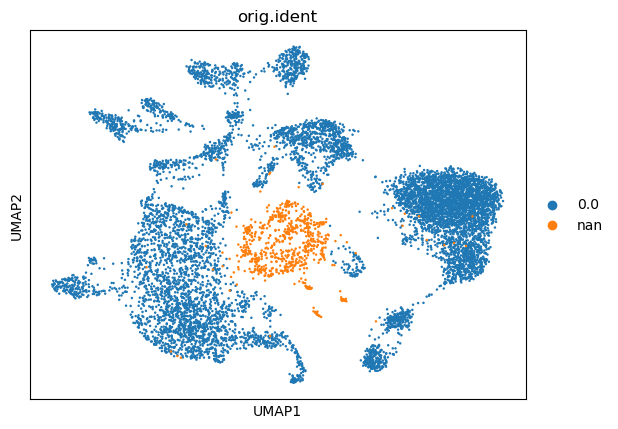

In [171]:
# Plot UMAP
sc.pl.umap(ident_as_str, color=['orig.ident'])


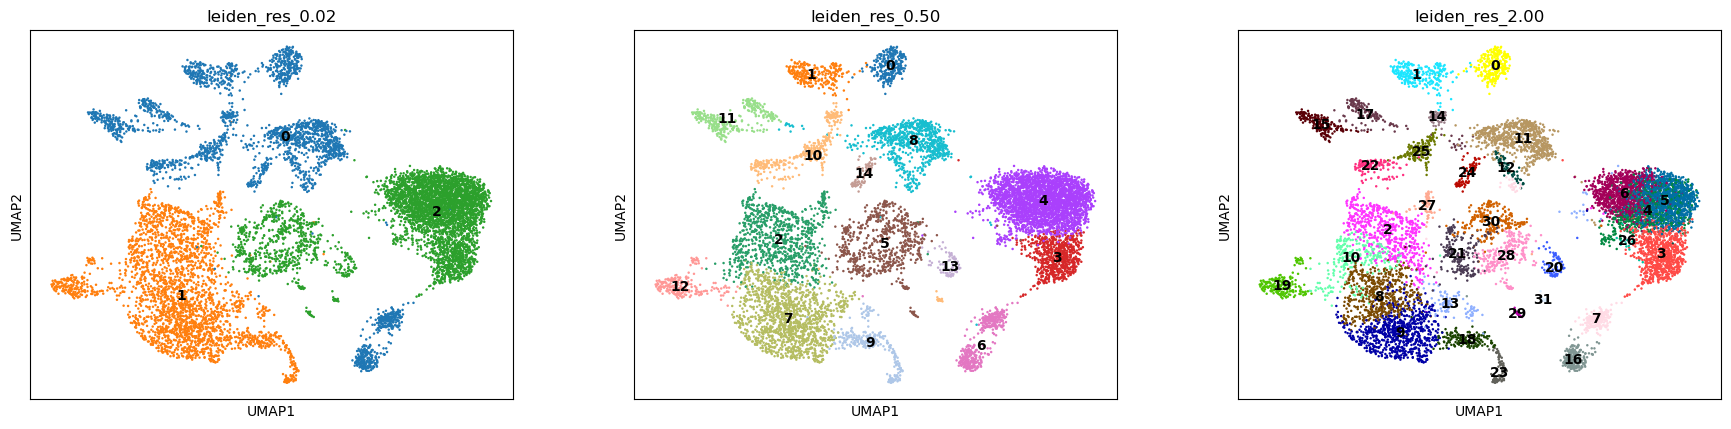

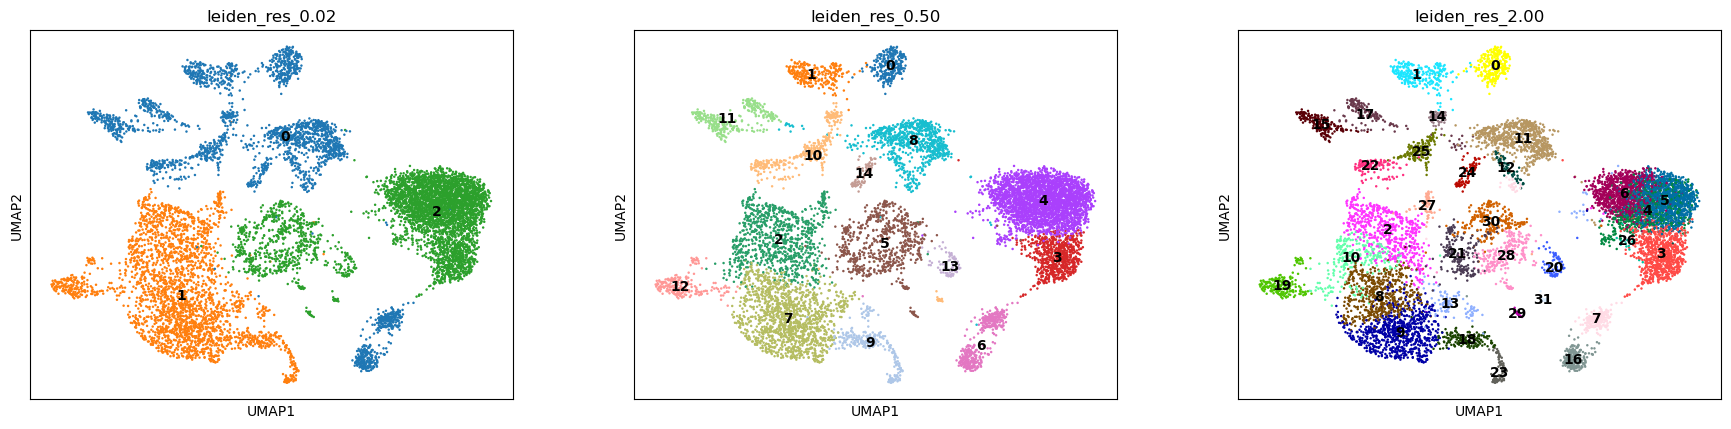

KeyError: "Could not find keys '['BLK', 'CCR7', 'CD247', 'CD4', 'CD8A', 'CD8B', 'CLEC10A', 'COL4A4', 'FCER1A', 'FCRL1', 'GZMA', 'GZMB', 'GZMH', 'GZMK', 'HSP90B1', 'IGHD', 'IGHM', 'IGKC', 'IL4R', 'IL7R', 'IRF4', 'ITGB1', 'JCHAIN', 'KLRG1', 'LEF1', 'PLCG2', 'PRDM1', 'SYNGR1', 'TCF7', 'TRBC2', 'XBP1']' in columns of `adata.obs` or in adata.var_names."

In [173]:
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(
        combined_data, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

sc.pl.umap(
    combined_data,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)

sc.pl.umap(
    combined_data,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)

marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1", "HBM", "GYPA"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

sc.pl.dotplot(combined_data, marker_genes, groupby="leiden_res_0.02", standard_scale="var")

#### Perform data integration using Scanorama

Scanorama manuscript: https://www.nature.com/articles/s41587-019-0113-3

In [174]:
# Convert AnnData objects to the format expected by Scanorama
scrna_expr = combined_data[combined_data.obs['dataset'] == '0'].X.toarray()
bulk_expr = combined_data[combined_data.obs['dataset'] == '1'].X.toarray()

# Integrate Data with Scanorama
integrated_data, integrated_genes = scanorama.integrate(
    [scrna_expr, bulk_expr],
    [common_genes, common_genes]
)


Found 3692 genes among all datasets
[[0.         0.71004243]
 [0.         0.        ]]
Processing datasets (0, 1)


In [175]:
print(vangalen_scrna_raw_adata.obs)


                    orig.ident  nCount_RNA  nFeature_RNA  n_genes
AAACCAAAGATTGAAG-1           0      1330.0           506      506
AAACCAAAGCAACCTA-1           0      3472.0          1460     1460
AAACCAAAGCGATGTC-1           0      5875.0          2315     2315
AAACCAAAGCTATGAT-1           0      7561.0          2260     2260
AAACCAAAGGTATCTG-1           0      5887.0          2394     2394
...                        ...         ...           ...      ...
TGTGTTAGTTTCACTT-1           0       870.0           523      523
TGTGTTGAGCAACTGC-1           0      6852.0          2157     2157
TGTGTTGAGTCAGGAG-1           0       566.0           382      382
TGTGTTGAGTGATGCC-1           0      7631.0          2398     2398
TGTGTTGAGTTACCCT-1           0      5120.0          2080     2080

[8764 rows x 4 columns]


In [176]:
# Verify dimensions
print(f"Integrated scRNA-seq data shape: {integrated_data[0].shape}")
print(f"Integrated bulk RNA-seq data shape: {integrated_data[1].shape}")
print(f"Integrated genes length: {len(integrated_genes)}")

# Create new AnnData objects with integrated data
# Since integrated_data has reduced dimensions, use the number of dimensions directly from integrated_data
integrated_scrna_adata = ad.AnnData(X=integrated_data[0], obs=vangalen_scrna_raw_adata.obs, var=pd.DataFrame(index=range(integrated_data[0].shape[1])))
integrated_bulk_data = ad.AnnData(X=integrated_data[1], obs=bulk_data.obs, var=pd.DataFrame(index=range(integrated_data[1].shape[1])))

# Combine the integrated data into a single AnnData object
integrated_adata = integrated_scrna_adata.concatenate(integrated_bulk_data, batch_key='batch', batch_categories=['scRNA', 'bulk'])


Integrated scRNA-seq data shape: (8764, 100)
Integrated bulk RNA-seq data shape: (707, 100)
Integrated genes length: 3692


/Users/hamiltsy/miniconda3/envs/jupyter/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/hamiltsy/miniconda3/envs/jupyter/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/var/folders/2k/tcn7b4hn3c9dls2qttgfhg84_b9kmx/T/ipykernel_15808/2646784230.py:12: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  integrated_adata = integrated_scrna_adata.concatenate(integrated_bulk_data, batch_key='batch', batch_categories=['scRNA', 'bulk'])


In [177]:
# Proceed with downstream analysis
sc.pp.scale(integrated_adata)
sc.tl.pca(integrated_adata)


In [178]:
# Generate UMAP plot
sc.pp.neighbors(integrated_adata)
sc.tl.umap(integrated_adata)


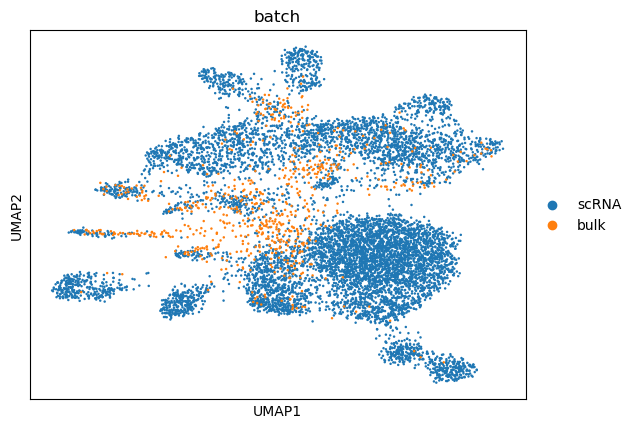

In [179]:
# Plot UMAP
sc.pl.umap(integrated_adata, color=['batch'])


In [180]:
celltype_as_str = integrated_adata
celltype_as_str.obs["leiden"] = celltype_as_str.obs["leiden"].astype(str)


KeyError: 'leiden'

KeyError: 'Could not find key leiden in .var_names or .obs.columns.'

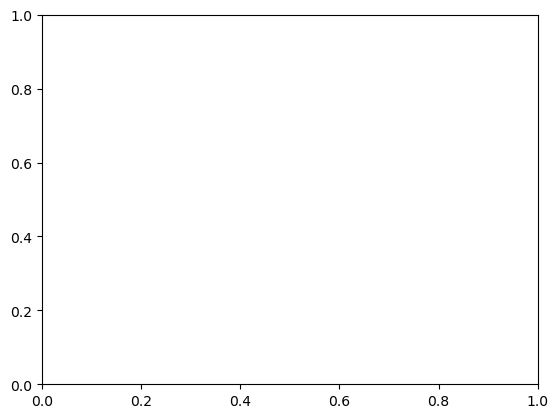

In [181]:
# Plot UMAP
sc.pl.umap(celltype_as_str, color=['leiden'])


In [182]:
print(integrated_adata)


AnnData object with n_obs × n_vars = 9471 × 100
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'n_genes', 'batch'
    var: 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'batch_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [183]:
print(integrated_scrna_adata)
print(integrated_bulk_data)


AnnData object with n_obs × n_vars = 8764 × 100
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'n_genes'
AnnData object with n_obs × n_vars = 707 × 100


In [184]:
# Plot the raw integration values, .X
sc.pp.neighbors(integrated_adata, use_rep='X')
sc.tl.umap(integrated_adata)


KeyError: 'Could not find key leiden in .var_names or .obs.columns.'

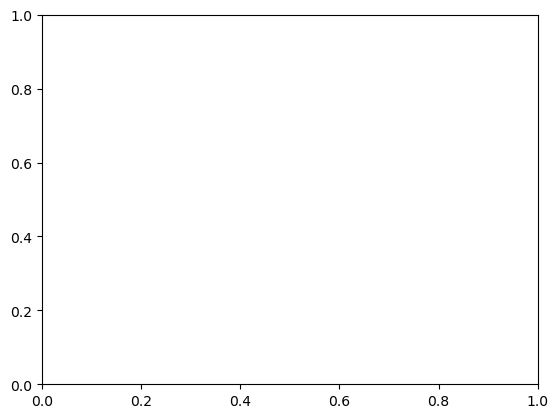

In [61]:
# Plot UMAP
sc.pl.umap(integrated_adata, color=['leiden'])


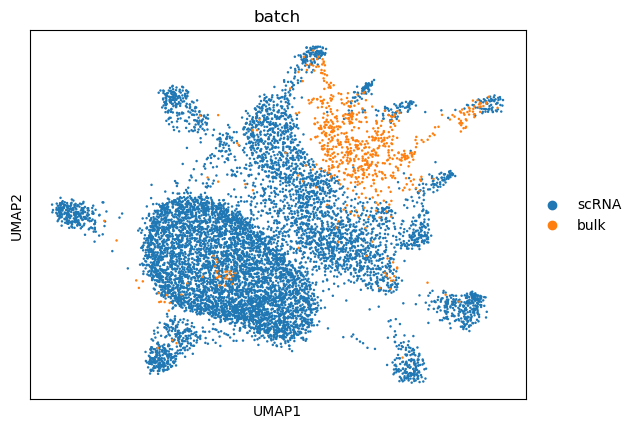

In [185]:
# Plot UMAP
sc.pl.umap(integrated_adata, color=['batch'])


In [63]:
# Save the Scanorama-integrated AnnData object to .h5ad file
save_dir = '/Users/hamiltsy/Documents/GitLab/Mutation/'
integrated_adata.write(save_dir + 'Scanorama-integrated_Beat_AML_K22_AML_adata.h5ad')
